## Import libs

In [2]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

In [3]:
!pip install --quiet scikit-learn tqdm
print("Required libraries unsloth, scikit-learn, and tqdm installed successfully.")

Required libraries unsloth, scikit-learn, and tqdm installed successfully.


## Connect to drive for test dataset and model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load model and tokenizer

In [4]:
test_data_path = "drive/MyDrive/mipd_test.jsonl"
MAX_NEW_TOKENS = 512
max_seq_length = 16384
base_model_dir = "drive/MyDrive/bielik-4.5b-base"
TEST_ROWS = None # None for whole dataset
lora_path = None #None for base model

In [5]:
from unsloth import FastLanguageModel
from google.colab import userdata
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = lora_path if lora_path else base_model_dir,
    max_seq_length = max_seq_length, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Load and prepare dataset

In [6]:
import json
from datasets import load_dataset

# 1. Load the test dataset
dataset_test = load_dataset("json", data_files={'test': test_data_path})

# 3. Define a function named format_prompt
def format_prompt(example):
    # Combine instruction for system message and input for the user message
    system_instruction = '''
Jesteś ekspertem w dziedzinie analizy mediów i lingwistyki, specjalizującym się w wykrywaniu propagandy, manipulacji poznawczej i błędów logicznych w tekstach w języku polskim.

**Twoje zadanie:**
Przeanalizuj dostarczony tekst wejściowy w języku polskim, aby zidentyfikować konkretne techniki manipulacji. Musisz oprzeć swoją analizę wyłącznie na dostarczonym tekście, szukając wzorców, które mają na celu wpłynięcie na opinię czytelnika za pomocą środków irracjonalnych lub zwodniczych.

**Dozwolone kategorie manipulacji:**
Jesteś ściśle ograniczony do klasyfikowania technik w następujących kategoriach. Nie używaj żadnych innych tagów.

1.  **REFERENCE_ERROR**: Cytaty, które nie popierają tezy, są zmyślone lub pochodzą z niewiarygodnych źródeł.
2.  **WHATABOUTISM**: Dyskredytowanie stanowiska oponenta poprzez zarzucanie mu hipokryzji, bez bezpośredniego odparcia jego argumentów.
3.  **STRAWMAN**: Przeinaczenie argumentu oponenta (stworzenie "chochoła"), aby łatwiej go było zaatakować.
4.  **EMOTIONAL_CONTENT**: Używanie języka nasyconego emocjami (strach, gniew, litość, radość) w celu ominięcia racjonalnego, krytycznego myślenia.
5.  **CHERRY_PICKING**: Zatajanie dowodów lub ignorowanie danych, które zaprzeczają argumentowi, przy jednoczesnym przedstawianiu tylko danych potwierdzających.
6.  **FALSE_CAUSE**: Błędne zidentyfikowanie przyczyny zjawiska (np. mylenie korelacji z przyczynowością).
7.  **MISLEADING_CLICKBAIT**: Nagłówki lub wstępy, które sensacyjnie wyolbrzymiają lub fałszywie przedstawiają faktyczną treść tekstu.
8.  **ANECDOTE**: Wykorzystywanie odosobnionych historii osobistych lub pojedynczych przykładów jako ważnego dowodu na ogólny trend lub fakt naukowy.
9.  **LEADING_QUESTIONS**: Pytania sformułowane w sposób sugerujący konkretną odpowiedź lub zawierające nieudowodnione założenie.
10. **EXAGGERATION**: Hiperboliczne stwierdzenia, które wyolbrzymiają fakty, aby wywołać reakcję.
11. **QUOTE_MINING**: Wyrywanie cytatów z kontekstu w celu zniekształcenia intencji pierwotnego autora.

**Format wyjściowy:**
Musisz odpowiedzieć pojedynczym, poprawnym obiektem JSON zawierającym dwa klucze:
1.  `"reasoning"`: Spójny akapit w **języku polskim** wyjaśniający, które techniki znaleziono i dlaczego. Musisz przytoczyć konkretną logikę lub fragmenty tekstu, aby uzasadnić swoją klasyfikację.
2.  `"discovered_techniques"`: Lista ciągów znaków (stringów) zawierająca dokładnie te tagi, które zdefiniowano powyżej. Jeśli nie znaleziono żadnych technik, zwróć pustą listę.

**Przykładowa struktura:**
{
    "reasoning": "Tekst stosuje [Nazwa Techniki], ponieważ autor sugeruje, że...",
    "discovered_techniques": ["NAZWA_TECHNIKI"]
}
    '''
    user_message = example['input']

    # Construct the ChatML formatted prompt
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": user_message},
    ]
    example['prompt'] = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # 5. Parse the output field into a Python list of strings (ground truth tags)
    try:
        # CLEANING STEP: Remove Markdown formatting
        clean_json = example['output'].replace("```json", "").replace("```", "").strip()
        example['tags'] = json.loads(clean_json)['discovered_techniques']
    except json.JSONDecodeError:
        # Handle cases where output might not be perfectly valid JSON (e.g., during training data prep)
        example['tags'] = [] # Assign empty list if parsing fails
        print(f"Warning: Could not parse output: {example['output']}")

    # 6. Return the modified example
    return example


if(TEST_ROWS):
  small_test_dataset = dataset_test['test'].select(range(TEST_ROWS))
else:
  small_test_dataset = dataset_test['test']
# 7. Apply the format_prompt function to the loaded test dataset
original_columns = small_test_dataset.column_names
dataset_test_formatted = small_test_dataset.map(format_prompt, remove_columns=original_columns)

print("Formatted prompts and ground truth tags generated for the test dataset.")
print(dataset_test_formatted)

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1521 [00:00<?, ? examples/s]

Formatted prompts and ground truth tags generated for the test dataset.
Dataset({
    features: ['prompt', 'tags'],
    num_rows: 1521
})


## Define evaluation function
Metric 1: Parsing Success Rate (Did it output valid JSON?).

Metric 2: Format Correction Rate (How many invalid jsons were recovered?)

Metric 3: Classification Performance (If parsable, how accurate?).


In [7]:
import json
import re
# from sklearn.metrics import f1_score # No longer used directly for the document-level F1 as defined by the user

def evaluate_response(response_text: str, ground_truth_tags: list):
    """
    Evaluates response with support for Dict format {"discovered_techniques": []}
    and Markdown stripping.
    """
    parsed_tags = []
    parsing_status = 'Failed'

    # 0. Pre-processing: Strip Markdown (Crucial for Strict Success)
    clean_text = response_text.replace("```json", "").replace("```", "").strip()

    # Attempt 1: Strict JSON parsing
    try:
        parsed_output = json.loads(clean_text)

        # CASE A: Output is the expected Dictionary
        if isinstance(parsed_output, dict):
            # Extract the specific key we trained on
            parsed_tags = parsed_output.get("discovered_techniques", [])
            # Check if the inner content is actually a list
            if not isinstance(parsed_tags, list):
                 # Try to force it if it's a string representation
                 parsed_tags = []
            parsing_status = 'Strict Success'

        # CASE B: Model outputted a raw List (unlikely but possible)
        elif isinstance(parsed_output, list):
            parsed_tags = parsed_output
            parsing_status = 'Strict Success'

        else:
            raise ValueError("Parsed output is not a Dict or List.")

    except (json.JSONDecodeError, ValueError):
        # Attempt 2: Regex-based correction
        # We look for the list explicitly
        match = re.search(r'\[(.*?)\]', clean_text, re.DOTALL)
        if match:
            extracted_content = f"[{match.group(1)}]"
            try:
                parsed_output_recovered = json.loads(extracted_content)
                if isinstance(parsed_output_recovered, list):
                    parsed_tags = parsed_output_recovered
                    parsing_status = 'Recovered'
            except (json.JSONDecodeError, ValueError):
                pass

    # Clean tags and convert to sets for easier set operations
    parsed_tags_set = set(str(tag) for tag in parsed_tags if tag is not None)
    ground_truth_tags_set = set(str(tag) for tag in ground_truth_tags if tag is not None)

    # --- Document-level F1 calculation (as per user definition) ---
    # TP = |pred ∩ gold|
    tp_doc = len(parsed_tags_set.intersection(ground_truth_tags_set))
    # FP = |pred − gold|
    fp_doc = len(parsed_tags_set.difference(ground_truth_tags_set))
    # FN = |gold − pred|
    fn_doc = len(ground_truth_tags_set.difference(parsed_tags_set))

    # F1_doc = 0 if TP=FP=FN=0, else 2*TP / (2*TP + FP + FN)
    if tp_doc == 0 and fp_doc == 0 and fn_doc == 0:
        f1_doc = 1.0 # Per user instruction for when both sets are empty
    else:
        f1_doc = (2 * tp_doc) / (2 * tp_doc + fp_doc + fn_doc)

    # Exact-match accuracy
    exact_match = (parsed_tags_set == ground_truth_tags_set)

    return {
        'parsing_status': parsing_status,
        'parsed_tags': list(parsed_tags_set), # Store as list for consistency
        'f1_doc': f1_doc,
        'exact_match': exact_match,
        'has_gold_labels': bool(ground_truth_tags_set), # To identify documents with non-empty gold labels
    }

## Load progress

In [8]:
import json
import os

checkpoint_file_path = "drive/MyDrive/evaluation_checkpoint.json"

evaluation_results = []
start_index = 0

if os.path.exists(checkpoint_file_path):
    with open(checkpoint_file_path, 'r') as f:
        evaluation_results = json.load(f)
    start_index = len(evaluation_results)
    print(f"Loaded {start_index} previous results from checkpoint: {checkpoint_file_path}")
else:
    print("No checkpoint found. Starting from scratch.")

Loaded 1260 previous results from checkpoint: drive/MyDrive/evaluation_checkpoint.json


## Infer all answers

In [9]:
from unsloth import FastLanguageModel
import torch
from tqdm import tqdm
import json

print(f"Loading Model for inference...")
FastLanguageModel.for_inference(model)

# --- RECTIFIED INFERENCE LOOP ---
print(f"Starting Long-Context Inference from index {start_index}...")

CHECKPOINT_FREQUENCY = 20

# Use range(start_index, total) to ensure 'i' always matches the dataset index
for i in tqdm(range(start_index, len(dataset_test_formatted)),
              desc="Processing",
              initial=start_index,
              total=len(dataset_test_formatted)):

    # Access the row directly by index
    example = dataset_test_formatted[i]
    prompt = example['prompt']
    ground_truth_tags = example['tags']

    # Tokenize
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Generate
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens = 256,
            use_cache = True,
            do_sample = False,
            temperature = 0.0,
            pad_token_id = tokenizer.pad_token_id
        )

    # Decode and slice off the input prompt
    generated_ids = output_ids[:, inputs.input_ids.shape[1]:]
    raw_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # --- 3. STANDARD EVALUATION ---
    if '}' in raw_output:
        raw_output = raw_output[:raw_output.find('}') + 1]

    result = evaluate_response(raw_output, ground_truth_tags)

    evaluation_results.append({
        'index': i,
        'original_prompt_len': inputs.input_ids.shape[1],
        'ground_truth': ground_truth_tags,
        'predicted': result['parsed_tags'],
        'f1_doc': result['f1_doc'],
        'exact_match': result['exact_match'],
        'parsing_status': result['parsing_status'],
        'raw_output': raw_output,
        'has_gold_labels': result['has_gold_labels']
    })

    # Clear cache to prevent OOM
    torch.cuda.empty_cache()

    # Save checkpoint periodically
    if (i + 1) % CHECKPOINT_FREQUENCY == 0:
        with open(checkpoint_file_path, 'w') as f:
            json.dump(evaluation_results, f)
        print(f" Checkpoint saved at index {i}. Total in list: {len(evaluation_results)}")

# Save final results
with open(checkpoint_file_path, 'w') as f:
    json.dump(evaluation_results, f)

print(f"Done. Processed {len(evaluation_results)} total documents.")

Loading Model for inference...
Starting Long-Context Inference from index 1260...


Processing:  84%|████████▍ | 1280/1521 [07:24<1:17:45, 19.36s/it]

 Checkpoint saved at index 1279. Total in list: 1280


Processing:  85%|████████▌ | 1300/1521 [14:44<1:20:33, 21.87s/it]

 Checkpoint saved at index 1299. Total in list: 1300


Processing:  87%|████████▋ | 1320/1521 [22:00<1:12:52, 21.76s/it]

 Checkpoint saved at index 1319. Total in list: 1320


Processing:  88%|████████▊ | 1340/1521 [29:09<1:06:57, 22.19s/it]

 Checkpoint saved at index 1339. Total in list: 1340


Processing:  89%|████████▉ | 1360/1521 [36:18<59:07, 22.04s/it]

 Checkpoint saved at index 1359. Total in list: 1360


Processing:  91%|█████████ | 1380/1521 [43:25<50:43, 21.58s/it]

 Checkpoint saved at index 1379. Total in list: 1380


Processing:  92%|█████████▏| 1400/1521 [50:26<43:24, 21.52s/it]

 Checkpoint saved at index 1399. Total in list: 1400


Processing:  93%|█████████▎| 1420/1521 [57:20<34:17, 20.37s/it]

 Checkpoint saved at index 1419. Total in list: 1420


Processing:  95%|█████████▍| 1440/1521 [1:04:16<27:21, 20.27s/it]

 Checkpoint saved at index 1439. Total in list: 1440


Processing:  96%|█████████▌| 1460/1521 [1:11:16<21:58, 21.62s/it]

 Checkpoint saved at index 1459. Total in list: 1460


Processing:  97%|█████████▋| 1480/1521 [1:18:38<17:48, 26.05s/it]

 Checkpoint saved at index 1479. Total in list: 1480


Processing:  99%|█████████▊| 1500/1521 [1:25:35<07:41, 21.97s/it]

 Checkpoint saved at index 1499. Total in list: 1500


Processing: 100%|█████████▉| 1520/1521 [1:32:49<00:21, 21.37s/it]

 Checkpoint saved at index 1519. Total in list: 1520


Processing: 100%|██████████| 1521/1521 [1:33:11<00:00, 21.42s/it]

Done. Processed 1521 total documents.


## Evaluate all answers

In [10]:
import json
from sklearn.metrics import multilabel_confusion_matrix # Import for confusion matrix

# --- 4. REPORTING ---
print("\n" + "="*60)
print(f"INFERENCE REPORT: {len(evaluation_results)} documents")
print("="*60)

if evaluation_results:
    total_docs = len(evaluation_results)
    strict_success_count = 0
    recovered_count = 0
    failed_count = 0

    all_ground_truth_for_cm = []
    all_predicted_for_cm = []
    all_unique_tags_set = set()

    # New metrics for document-level F1 and exact match
    total_f1_doc = 0.0
    total_f1_doc_non_empty_gold = 0.0
    non_empty_gold_docs_count = 0
    exact_matches_count = 0

    # Add comments explaining why document-level F1 is needed
    print("\n### Importance of Document-Level F1 Score ###")
    print("Document-level F1 is crucial for evaluating multi-label classification models, especially when dealing with imbalanced datasets or documents with varying numbers of labels (including documents with no ground truth labels). Unlike traditional micro or macro F1 scores which aggregate metrics across all labels, document-level F1 assesses the quality of predictions for each individual document. This approach prevents models from artificially inflating performance by correctly predicting 'no labels' for many documents, or by performing well on frequently occurring labels while failing on rare ones. It provides a more faithful representation of the model's ability to assign the correct set of labels to each document.")
    print("----------------------------------------------\n")

    for r in evaluation_results:
        if r['parsing_status'] == 'Strict Success':
            strict_success_count += 1
        elif r['parsing_status'] == 'Recovered':
            recovered_count += 1
        else:
            failed_count += 1

        all_ground_truth_for_cm.append(r['ground_truth'])
        all_predicted_for_cm.append(r['predicted'])
        all_unique_tags_set.update(r['ground_truth']) # Only update with ground truth tags

        total_f1_doc += r['f1_doc']
        if r['has_gold_labels']:
            total_f1_doc_non_empty_gold += r['f1_doc']
            non_empty_gold_docs_count += 1

        if r['exact_match']:
            exact_matches_count += 1

    parsing_success_rate = strict_success_count / total_docs
    format_correction_rate = recovered_count / total_docs
    total_parsing_success = (strict_success_count + recovered_count) / total_docs

    print(f"\nParsing Success Rate (Strict JSON): {parsing_success_rate:.4f} ({strict_success_count}/{total_docs})")
    print(f"Format Correction Rate (Recovered JSON): {format_correction_rate:.4f} ({recovered_count}/{total_docs})")
    print(f"Total Parsing Success (Strict + Recovered): {total_parsing_success:.4f} ({strict_success_count + recovered_count}/{total_docs})")

    # New document-level metrics
    mean_f1_doc_all_docs = total_f1_doc / total_docs
    print(f"\nMean Document-Level F1 (all docs): {mean_f1_doc_all_docs:.4f}")

    if non_empty_gold_docs_count > 0:
        mean_f1_doc_non_empty = total_f1_doc_non_empty_gold / non_empty_gold_docs_count
        print(f"Mean Document-Level F1 (excluding empty gold-label docs): {mean_f1_doc_non_empty:.4f}")
    else:
        print("Mean Document-Level F1 (excluding empty gold-label docs): N/A (No documents with gold labels found)")

    exact_match_accuracy = exact_matches_count / total_docs
    print(f"Exact-Match Accuracy: {exact_match_accuracy:.4f} ({exact_matches_count}/{total_docs})")

    # Prepare data for Confusion Matrix (existing logic, unchanged)
    all_unique_tags = sorted(list(all_unique_tags_set))
    if not all_unique_tags:
        print("\nNo unique tags found in ground truth or predictions for confusion matrix.")
    else:
        y_true_bin = [[1 if tag in gt_list else 0 for tag in all_unique_tags] for gt_list in all_ground_truth_for_cm]
        y_pred_bin = [[1 if tag in pred_list else 0 for tag in all_unique_tags] for pred_list in all_predicted_for_cm]
        cm = multilabel_confusion_matrix(y_true_bin, y_pred_bin)

        print("\n--- Confusion Matrix (per tag) ---")
        for i, tag in enumerate(all_unique_tags):
            tn, fp, fn, tp = cm[i].ravel()
            print(f"Tag: {tag}")
            print(f"  True Negatives (TN): {tn}")
            print(f"  False Positives (FP): {fp}")
            print(f"  False Negatives (FN): {fn}")
            print(f"  True Positives (TP): {tp}")
            print("-" * 30)


    # 2. Print Sample Table
    print("\n--- Sample Results (First 10) ---")
    print(f"{'F1_Doc':<10} | {'Exact Match':<12} | {'Ground Truth':<30} | {'Model Output (Reasoning & Tags)':<80}")
    print("-" * 135)

    for res in evaluation_results[:10]:
        gt_str = str(res['ground_truth'])
        gt_display = (gt_str[:100] + '..') if len(gt_str) > 30 else gt_str

        output_display = ""
        try:
            parsed_output = json.loads(res['raw_output'])
            reasoning = parsed_output.get('reasoning', 'No reasoning provided')
            discovered_techniques = parsed_output.get('discovered_techniques', [])
            output_display = f"Reasoning: {reasoning[:100]}... | Tags: {str(discovered_techniques)[:100]}..."
        except json.JSONDecodeError:
            output_display = (res['raw_output'][:80] + '..') if len(res['raw_output']) > 80 else res['raw_output']

        print(f"{res['f1_doc']:.4f}     | {str(res['exact_match']):<12} | {gt_display:<30} | {output_display:<80}")

    print("-" * 135)
else:
    print("No results generated.")


INFERENCE REPORT: 1521 documents

### Importance of Document-Level F1 Score ###
Document-level F1 is crucial for evaluating multi-label classification models, especially when dealing with imbalanced datasets or documents with varying numbers of labels (including documents with no ground truth labels). Unlike traditional micro or macro F1 scores which aggregate metrics across all labels, document-level F1 assesses the quality of predictions for each individual document. This approach prevents models from artificially inflating performance by correctly predicting 'no labels' for many documents, or by performing well on frequently occurring labels while failing on rare ones. It provides a more faithful representation of the model's ability to assign the correct set of labels to each document.
----------------------------------------------


Parsing Success Rate (Strict JSON): 0.2005 (305/1521)
Format Correction Rate (Recovered JSON): 0.3406 (518/1521)
Total Parsing Success (Strict + Reco

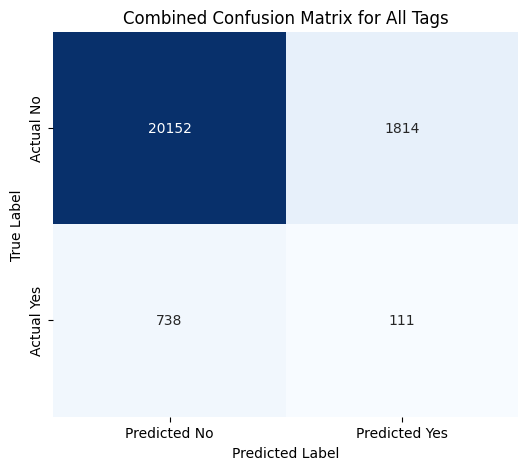

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize aggregated confusion matrix components
total_tn = 0
total_fp = 0
total_fn = 0
total_tp = 0

# Aggregate confusion matrix components from individual tag matrices
for i, tag in enumerate(all_unique_tags):
    tn, fp, fn, tp = cm[i].ravel()
    total_tn += tn
    total_fp += fp
    total_fn += fn
    total_tp += tp

# Create the combined confusion matrix
combined_cm = np.array([
    [total_tn, total_fp],
    [total_fn, total_tp]
])

# Plot the combined confusion matrix
fig = plt.figure(figsize=(6, 5))
sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Combined Confusion Matrix for All Tags')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()